
## Definition of the optimal control problem

$$
    \left\{
    \begin{array}{l}
        \displaystyle \min \int_0^T \mathbb{1}_{K^c}(\theta(t)) dt, \\[0.5em]
        \dot{\theta}(t)  = 2 + u(t),        \\[0.5em]
        u(t) \in [-1, 1],\\[0.5em]
        \theta(0) = 0.
    \end{array}
    \right.
$$

with $K$ denotes $\bigcup_{k} [2k\pi , (2k+1)\pi]$.


In [1]:
# For direct methods
using JuMP  # NLP modeling
using Ipopt # NLP solving
# To plot solutions
using Plots
using Plots.PlotMeasures

In [2]:
mutable struct DirectSSS
    t ; θ ; z ; u  
end

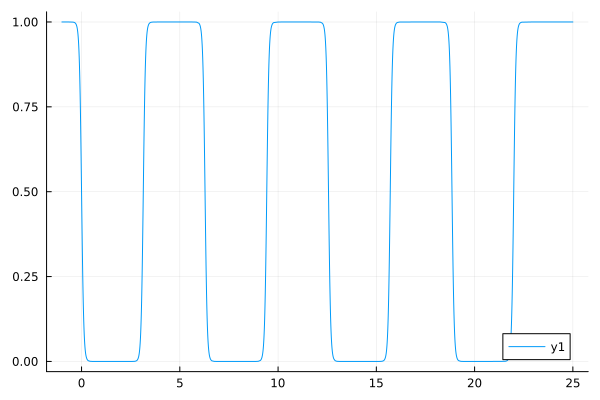

In [3]:
function indicator(x, a, b)
    k = 18
    g1 = 1 / (1 + exp(-k * (x - a)))  
    g2 = 1 / (1 + exp(-k * (b - x)))  
    return g1 * g2
end

f(x) =1 - (indicator(x, 0, π) + indicator(x, 2*π, 3*π) + indicator(x, 4*π, 5*π) + indicator(x, 6*π, 7*π)) ; 

plot(f, -1., 25)

### Direct method

In [4]:
function example(θ0, tf; solution=[], nsteps=500, display=true)

    # Create JuMP model, using Ipopt as the solver
    if display
        pl = 5
    else
        pl = 1
    end
    sys = Model(optimizer_with_attributes(Ipopt.Optimizer, "print_level" => pl))
    set_optimizer_attribute(sys,"tol",1e-9)
    set_optimizer_attribute(sys,"constr_viol_tol",1e-9)
    set_optimizer_attribute(sys,"max_iter",700)

    N     = nsteps     # Grid size
    
    @variables(sys, begin
                θ[1:N+1]  
                z[1:N+1]   
        - 1. ≤  u[1:N+1]  ≤ 1.                   
    end)
    
    T  = tf
    
    Δt = T/N 
    
    # Objective
    @objective(sys, Min, z[N+1] )

    # Boundary constraints
    @constraints(sys, begin
        con_θ0,   θ[1]   == θ0
        con_z0,   z[1]   == 0. 
  #     con_xu0, xu[1]   == 0. 
        end)
        

    # Dynamics
    @NLexpression(sys, dθ[j = 1:N+1] ,  2. + u[j] )
    @NLexpression(sys, dz[j = 1:N+1] ,  f(θ[j])   )
   #@NLexpression(sys, dxu[j = 1:N+1],  u[j]^2    )
    
    # Dynamics with Crank-Nicolson scheme
    @NLconstraints(sys, begin
        con_dθ[j=1:N] , θ[j+1] == θ[j] + 0.5 * Δt * (dθ[j+1] + dθ[j])
        con_dz[j=1:N] , z[j+1] == z[j] + 0.5 * Δt * (dz[j+1] + dz[j])
     #  con_dxu[j=1:N], xu[j+1] == xu[j] + 0.5 * Δt * (dxu[j+1] + dxu[j])

        end)

 

    # Solve for the control and state
    if display
        println("Solving...")
    end
    status = optimize!(sys)
    if display
        println()
    end

    # Display results
    if display
        if termination_status(sys) == MOI.OPTIMAL
            println("  Solution is optimal")
        elseif  termination_status(sys) == MOI.LOCALLY_SOLVED
            println("  (Local) solution found")
        elseif termination_status(sys) == MOI.TIME_LIMIT && has_values(sys)
            println("  Solution is suboptimal due to a time limit, but a primal solution is available")
        else
            error("  The model was not solved correctly.")
        end
        println("  objective value = ", objective_value(sys))
        println()
    end

    # Retrieves values
    θ = value.(θ)[:]
    z = value.(z)[:]
    u  = value.(u)[:]
    t  = (0:N) * value.(Δt)

      
    return DirectSSS(t , θ , z , u )
end;

In [17]:
# Resolution
θ0    = 0.       #initial cond
tf    = 6.5      #final time

sol   = example(θ0, tf, nsteps=500);


Solving...
This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     4002
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1000

Total number of variables............................:     1503
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1002
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  0.0000000e+00 2.60e-02 3.30e-02  -1.0 0.00e+00    -  0.00e+00

┌ Warning: Function f automatically registered with 1 arguments.
│ 
│ Calling the function with a different number of arguments will result in an
│ error.
│ 
│ While you can safely ignore this warning, we recommend that you manually
│ register the function as follows:
│ ```Julia
│ model = Model()
│ register(model, :f, 1, f; autodiff = true)
│ ```
└ @ MathOptInterface.Nonlinear ~/.julia/packages/MathOptInterface/fTxO0/src/Nonlinear/operators.jl:370


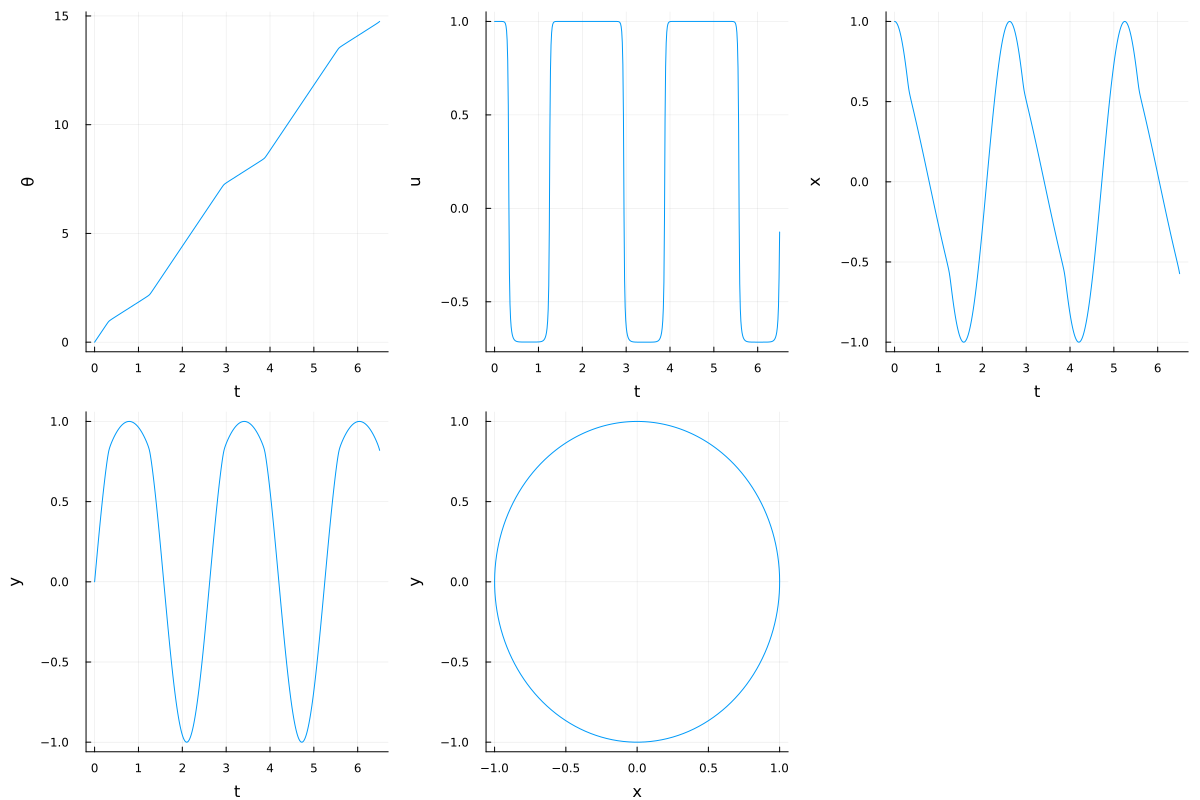

In [22]:
# Plots
t  = sol.t
θ  = sol.θ
z  = sol.z
u  = sol.u

x  = cos.(θ)  
y  = sin.(θ) 

x_plot     = plot(t, x,  xlabel = "t", ylabel = "x",  legend = false)
y_plot     = plot(t, y,  xlabel = "t", ylabel = "y",  legend = false)
xy_plot    = plot(x, y,  xlabel = "x", ylabel = "y",  legend = false)


θ_plot    = plot(t, θ,  xlabel = "t", ylabel = "θ",  legend = false)

u_plot    = plot(t, u,   xlabel = "t", ylabel = "u",   legend = false, size=(800,400)) #, linetype=:steppre)


plot(θ_plot, u_plot ,x_plot,y_plot,xy_plot, layout = (2,3), size=(1200,800), left_margin=5mm)

In [23]:
using Animations
using Reel

In [24]:
 # create an animation
animx = @animate for i = 1:length(t)
    plot(x[1:i], y[1:i], xlim=(-2.,2.), ylim=(-2.,2.), xlabel="x", ylabel="y", label="trajectory", linecolor=:blue)
    scatter!([x[i]], [y[i]], label=false, markercolor=:blue)
end


Plots.Animation("/tmp/jl_hexWKS", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000492.png", "000493.png", "000494.png", "000495.png", "000496.png", "000497.png", "000498.png", "000499.png", "000500.png", "000501.png"])

[ Info: Saved animation to /home/anas/Documents/control-loss/lotka volterra/animationx.gif


Plots.AnimatedGif("/home/anas/Documents/control-loss/lotka volterra/animationx.gif")
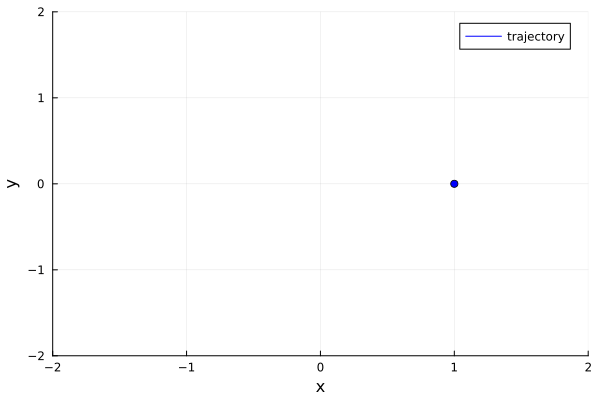

In [25]:
gif(animx, "animationx.gif", fps = 150)